In this tutorial, we will explore a simple case of logistic regression using the package sklearn and yfinance. 

The context is as follows:

My desk would like to understand the relationships between the rise/fall of the Google share (binary value) and the rises/falls of a series of shares over the same day (continuous values). 

To begin with, they ask me to calibrate a logistic regression model that predicts for each day whether the Google share will rise or fall, with the only input being the rise or fall of the other shares on the same day in dollars. 

This model will be large, so the desk wants to reduce it to keep only a small set of stocks to track that best predicts Google's rise/fall.

The aim of this model is to analyse the relationships between stocks to help create risk scenarios.

They also asked me to add two variables: 
- Avg day: The average of feature stocks over the day 
- Avg day GAFAM: The average of Apple, Meta, Microsoft and Amazon over the day.

The dataset runs from 2018 to 2024 and you will keep 80% of the dataset to train your model.

In [54]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns

companies = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'TSLA', 'BRK-B', 'JPM', 'JNJ', 'V', 
             'WMT', 'PG', 'UNH', 'NVDA', 'HD', 'DIS', 'PYPL', 'MA', 'VZ', 'ADBE']

data = yf.download(companies, start='2018-01-01', end='2024-01-01')['Adj Close']
returns = data.diff().dropna().reset_index().drop("Date", axis = 1)

returns

[*********************100%***********************]  20 of 20 completed


Ticker,AAPL,ADBE,AMZN,BRK-B,DIS,GOOGL,HD,JNJ,JPM,MA,META,MSFT,NVDA,PG,PYPL,TSLA,UNH,V,VZ,WMT
0,-0.007069,3.339996,0.759499,2.569992,0.461090,0.912197,0.826996,1.096268,0.089798,1.834366,3.237640,0.370598,0.324455,-0.091339,2.910004,-0.218668,2.091537,1.086159,-0.751328,0.254629
1,0.188217,2.180008,0.269501,0.900009,-0.048027,0.211227,1.265915,-0.008224,1.263519,1.911224,-0.338699,0.704163,0.027697,0.531494,-0.019997,-0.175333,0.874496,0.409698,0.116104,0.026649
2,0.463436,2.119995,0.977501,0.729996,-0.585991,0.723881,1.679352,0.956100,-0.574348,3.102112,2.510406,1.000610,0.044761,0.049797,1.969994,0.130667,3.858536,2.648766,-0.081955,0.174696
3,-0.152905,-0.300003,0.886497,1.320007,-1.537010,0.195290,-0.388229,0.148384,0.131294,0.461777,1.424561,0.083382,0.163216,0.398621,0.350006,1.322001,-3.579071,0.457344,-0.061478,0.438202
4,-0.004707,1.660004,0.291500,0.279999,-0.076859,-0.070744,0.894592,1.854599,0.451271,0.221176,-0.408447,-0.055573,-0.001483,-0.556396,0.139999,-0.181334,1.009720,-0.219109,-0.131252,-0.361223
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1503,-1.074707,-1.390015,-0.419998,0.329987,-0.991013,1.066147,-0.370911,0.600967,-0.097183,0.655243,-0.697296,1.032318,-0.159954,0.995209,-0.220001,-1.960007,0.423340,-1.101593,0.055275,0.609367
1504,-0.547333,-0.489990,-0.009995,0.359985,-0.069374,0.029892,0.702789,0.659134,0.961929,-0.426880,1.434509,0.079376,0.448868,0.643997,0.720001,4.069992,-0.275635,0.724487,-0.009216,-0.079060
1505,0.099533,-2.179993,-0.070007,0.120026,-0.564880,-1.145859,-0.761383,0.203568,0.981384,0.684998,2.988556,-0.585602,0.137962,0.117065,0.119999,4.830017,2.717407,-0.228271,-0.156601,0.484200
1506,0.427902,-0.559998,0.040009,0.619995,0.019821,-0.139496,-1.141998,0.222931,0.874496,1.945862,0.488129,1.200989,0.104973,-0.321991,0.400002,-8.260010,2.077454,1.458832,0.165817,-0.102108


As we can see in the Dataframe, we have 1508 observations for 20 companies, including the target company.


In [55]:
target = "GOOGL"

binaries = returns.copy()
binaries["TARGET"] = (binaries[target] > 0.0).astype(float)
binaries = binaries.drop(target, axis = 1)

binaries["AVG_day"] = binaries.mean(axis =1)
binaries["AVG_day_GAFAM"] = binaries[['AAPL', 'MSFT', 'AMZN', 'META']].mean(axis =1)

binaries.dropna(inplace=True)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

preprocesser = StandardScaler()
train, test = train_test_split(binaries, test_size=0.2, shuffle=True, random_state=321, stratify=binaries["TARGET"])

X_train = train.drop(columns = ["TARGET"])
X_train = preprocesser.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=train.drop(columns = ["TARGET"]).columns)
y_train = train["TARGET"]


X_test = test.drop(columns = ["TARGET"])
X_test = preprocesser.transform(X_test)
X_test = pd.DataFrame(X_test, columns=test.drop(columns = ["TARGET"]).columns)
y_test = test["TARGET"]

In [56]:
model = LogisticRegression(fit_intercept=False, penalty = None)
model.fit(X_train, y_train)

model.score(X_train, y_train)

1.0

In [57]:
model.score(X_test, y_test)

1.0

In [58]:
coef_logistic = pd.DataFrame({"Variables" : train.drop(columns = ["TARGET"]).columns,
                              "Coef" : model.coef_[0]})
coef_logistic.sort_values("Coef")

,Variables,Coef
1,ADBE,-163.221355
14,TSLA,-129.011051
15,UNH,-105.022692
8,MA,-99.632278
9,META,-74.914436
5,HD,-72.364627
20,AVG_day_GAFAM,-64.286930
13,PYPL,-63.607377
3,BRK-B,-57.999527
16,V,-57.803323


This first model uses too many variables. We will then use a Lasso regression in order to reduce coefficients.

In [59]:
model = LogisticRegression(fit_intercept=False, penalty = "l1", C = 0.1, solver="liblinear")
model.fit(X_train, y_train)

model.score(X_train, y_train)

0.818407960199005

In [60]:
model.score(X_test, y_test)

0.847682119205298

In [61]:
coef_logistic = pd.DataFrame({"Variables" : train.drop(columns = ["TARGET"]).columns,
                              "Coef" : model.coef_[0]})
coef_logistic[coef_logistic["Coef"] != 0].sort_values("Coef")

,Variables,Coef
5,HD,-0.044567
12,PG,-0.020512
16,V,0.009820
15,UNH,0.027686
7,JPM,0.065044
4,DIS,0.073732
8,MA,0.126057
10,MSFT,0.274479
2,AMZN,0.515055
19,AVG_day,0.919822


Let's analyse the distribution of increases and decreases in the test and training targets. What do we find? 

In [62]:
#For train set

number_of_ups = y_train[y_train > 0].count()
number_of_downs = y_train[y_train == 0].count()

print(f"1 : {number_of_ups} \n\n0 : {number_of_downs}")
print(f"\nproportion of 1 : {number_of_ups / number_of_downs}")

1 : 638 

0 : 568

proportion of 1 : 1.1232394366197183


In [63]:
#For test set
number_of_ups =  y_test[y_test > 0].count()
number_of_downs = y_test[y_test == 0].count()

print(f"1 : {number_of_ups} \n\n0 : {number_of_downs}")
print(f"\nproportion of 1 : {number_of_ups / number_of_downs}")

1 : 160 

0 : 142

proportion of 1 : 1.1267605633802817


In [65]:
from sklearn.metrics import confusion_matrix

#Predictions for the second model, using Lasso regression
y_pred = model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
cm

array([[115,  27],
       [ 19, 141]])

Let's plot the confusion matrix

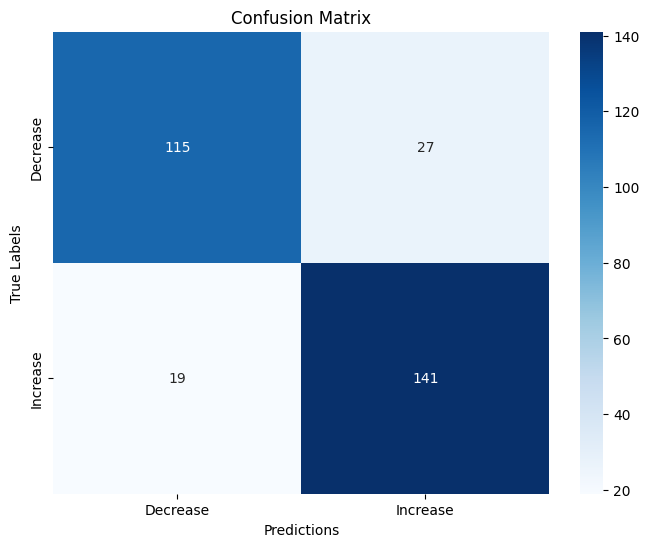

In [66]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Decrease', 'Increase'], yticklabels=['Decrease', 'Increase'])
plt.xlabel('Predictions')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


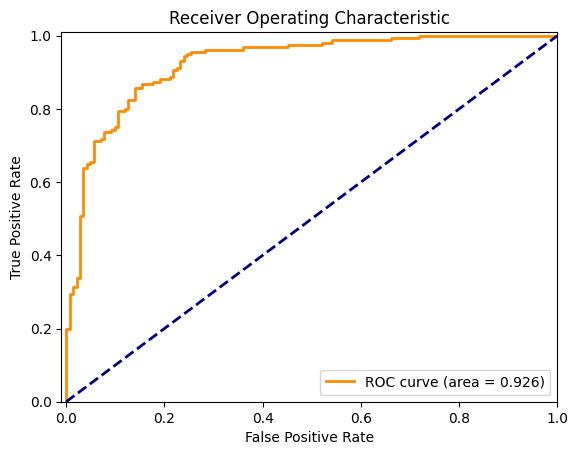

ROC AUC : 0.9255281690140845


In [67]:
from sklearn.metrics import roc_curve, roc_auc_score


y_pred_prob = model.predict_proba(X_test)[:, 1]


fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = roc_auc_score(y_test, y_pred_prob)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

print(f"ROC AUC : {roc_auc}")

Now we will do it with a L2 penalty (which means Ridge regression)

model score: 0.8159203980099502
confusion matrix: 
[[111  31]
 [ 20 140]]
accuracy : 0.8311258278145696


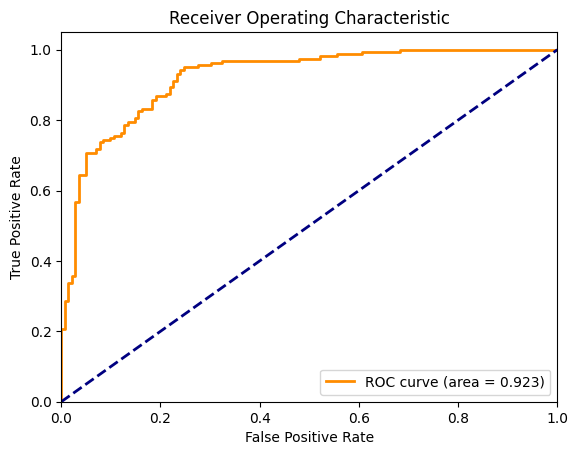

ROC AUC : 0.9230633802816902


In [72]:
model = LogisticRegression(fit_intercept=False, penalty = "l2", C = 0.1, solver="liblinear")
model.fit(X_train, y_train)

score = model.score(X_train, y_train)
print(f"model score: {score}")

y_pred = model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
print(f"confusion matrix: \n{cm}")

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print(f"accuracy : {accuracy}")
y_pred_prob = model.predict_proba(X_test)[:, 1]


fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = roc_auc_score(y_test, y_pred_prob)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

print(f"ROC AUC : {roc_auc}")

In [69]:
from sklearn.feature_selection import RFE

rfe = RFE(estimator=LogisticRegression(fit_intercept=False, penalty='l2'), n_features_to_select=5)
rfe.fit(X_train, y_train)

selected_features = X_train.columns[rfe.support_]
print(f'Selected Features: {selected_features}')

# Réduction des données d'entraînement et de test aux caractéristiques sélectionnées
X_train_rfe = rfe.transform(X_train)
X_test_rfe = rfe.transform(X_test)


Selected Features: Index(['AMZN', 'HD', 'MSFT', 'AVG_day', 'AVG_day_GAFAM'], dtype='object', name='Ticker')


In [47]:
# Initialisation et entraînement du modèle de régression logistique avec les caractéristiques sélectionnées
model_rfe = LogisticRegression(fit_intercept=False, penalty="l2")
model_rfe.fit(X_train_rfe, y_train)

# Prédiction des classes et des probabilités
y_pred_rfe = model_rfe.predict(X_test_rfe)
y_pred_prob_rfe = model_rfe.predict_proba(X_test_rfe)[:, 1]


from sklearn.metrics import accuracy_score, roc_auc_score
# Évaluation des performances
rfe_accuracy = accuracy_score(y_test, y_pred_rfe)
rfe_roc_auc = roc_auc_score(y_test, y_pred_prob_rfe)
print(f'RFE Accuracy: {rfe_accuracy}')
print(f'RFE ROC AUC: {rfe_roc_auc}')


RFE Accuracy: 0.8576158940397351
RFE ROC AUC: 0.9276848591549295


As we can see, the AUC is bigger for the RFE model than for the Ridge model with all the features (0.928 vs 0.923)

The Accuracy is also better for the RFE model (0.858 vs 0.831)

Finally, i will try a model that takes into account the potential discrepancies in the target by using the argument class_weight "balanced"

In [80]:
final_model = LogisticRegression(penalty = "l2", C=.6, class_weight="balanced")
final_model.fit(X_train, y_train)

LogisticRegression(C=0.6, class_weight='balanced')

[]

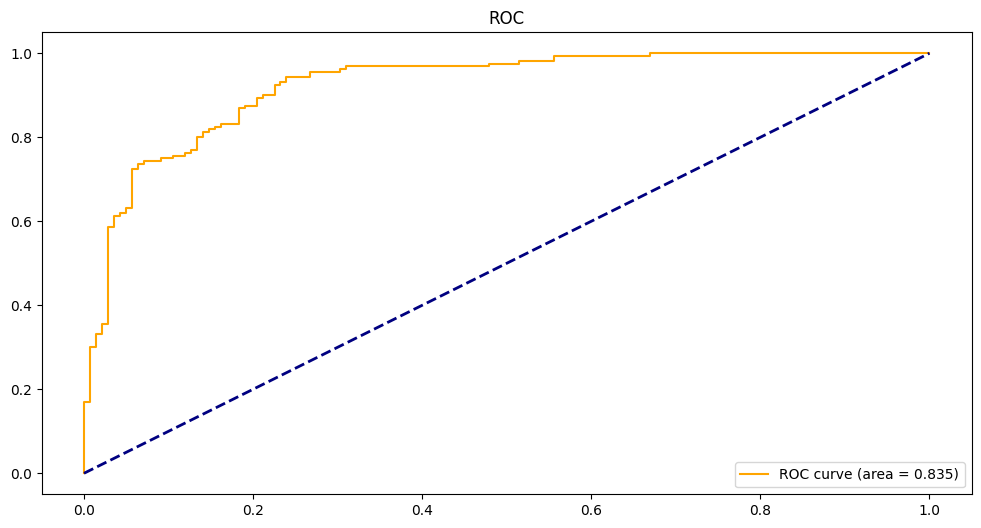

In [111]:
final_model.score(X_test, y_test)
y_pred = final_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

y_pred_prob = final_model.predict_proba(X_test)[:,-1]
tpr, fpr, threshold = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(12,6))
plt.plot(tpr, fpr, color="orange",label='ROC curve (area = %0.3f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc="lower right")
plt.title("ROC")
plt.plot()